In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
speech_path = "/content/drive/MyDrive/speech_emotion_data/Audio_Speech_Actors_01-24"
song_path   = "/content/drive/MyDrive/speech_emotion_data/Audio_Song_Actors_01-24"

In [ ]:
import os
import glob

# Find all .wav files recursively
speech_wavs = glob.glob(speech_path + "/**/*.wav", recursive=True)
song_wavs = glob.glob(song_path + "/**/*.wav", recursive=True)

all_wavs = speech_wavs + song_wavs

print(f"🎤 Total Speech WAV files: {len(speech_wavs)}")
print(f"🎵 Total Song WAV files: {len(song_wavs)}")
print(f"📦 Total Combined WAV files: {len(all_wavs)}")

# Optional: print first few file paths
print("\nSample file paths:")
for f in all_wavs[:5]:
    print(f)

🎤 Total Speech WAV files: 1440
🎵 Total Song WAV files: 1012
📦 Total Combined WAV files: 2452

Sample file paths:
/content/drive/MyDrive/speech_emotion_data/Audio_Speech_Actors_01-24/Actor_08/03-01-03-02-02-02-08.wav
/content/drive/MyDrive/speech_emotion_data/Audio_Speech_Actors_01-24/Actor_08/03-01-03-02-01-01-08.wav
/content/drive/MyDrive/speech_emotion_data/Audio_Speech_Actors_01-24/Actor_08/03-01-02-02-01-01-08.wav
/content/drive/MyDrive/speech_emotion_data/Audio_Speech_Actors_01-24/Actor_08/03-01-03-01-01-02-08.wav
/content/drive/MyDrive/speech_emotion_data/Audio_Speech_Actors_01-24/Actor_08/03-01-04-01-01-01-08.wav


In [ ]:
import numpy as np
import librosa
import os
from tqdm import tqdm

emotion_dict = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

def get_gender(actor_id):
    return 0 if int(actor_id) % 2 == 0 else 1

# Paths
speech_path = "data/Audio_Speech_Actors_01-24"
song_path   = "data/Audio_Song_Actors_01-24"
all_paths = [speech_path, song_path]

sr = 22050
n_mfcc = 40
n_mels = 125
n_chroma = 10

X = []
y = []

for folder in all_paths:
    for root, _, files in os.walk(folder):
        for file in tqdm(files, desc=os.path.basename(root)):
            if file.endswith(".wav"):
                parts = file.split("-")
                if len(parts) != 7:
                    continue
                emotion_code = parts[2]
                intensity = int(parts[3])
                actor_id = parts[6].split(".")[0]
                gender = get_gender(actor_id)
                emotion = emotion_dict.get(emotion_code)
                if emotion is None:
                    continue

                try:
                    path = os.path.join(root, file)
                    y_audio, _ = librosa.load(path, sr=sr)

                    mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=n_mfcc)
                    mfcc_mean = np.mean(mfcc, axis=1)

                    mel = librosa.feature.melspectrogram(y=y_audio, sr=sr, n_mels=n_mels)
                    mel_db = librosa.power_to_db(mel)
                    mel_mean = np.mean(mel_db, axis=1)

                    zcr = np.mean(librosa.feature.zero_crossing_rate(y_audio))
                    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y_audio, sr=sr))
                    chroma = librosa.feature.chroma_stft(y=y_audio, sr=sr, n_chroma=n_chroma)
                    chroma_mean = np.mean(chroma, axis=1)

                    features = np.concatenate([
                        mfcc_mean, mel_mean, [zcr], [bandwidth], chroma_mean, [intensity], [gender]
                    ])
                    X.append(features)
                    y.append(emotion)

                except Exception as e:
                    print(f"❌ Error: {file} — {e}")

X = np.array(X)
y = np.array(y)

np.save("/content/drive/MyDrive/speech_emotion_data/X_ann_features.npy", X)
np.save("/content/drive/MyDrive/speech_emotion_data/y_ann_labels.npy", y)

In [16]:
from google.colab import files
files.download('/content/drive/MyDrive/speech_emotion_data/X_ann_features.npy')
files.download('/content/drive/MyDrive/speech_emotion_data/y_ann_labels.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
print("Features extracted:", X.shape)
print("Labels extracted  :", y.shape)

Features extracted: (2452, 179)
Labels extracted  : (2452,)


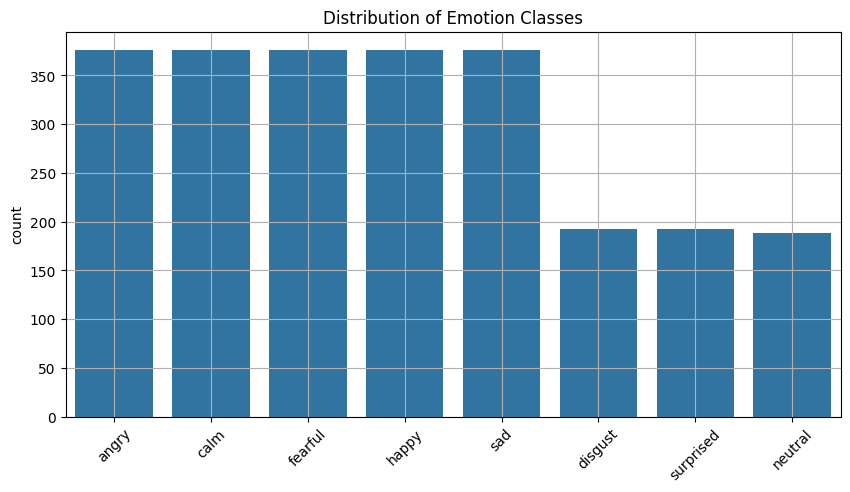

{np.str_('angry'): np.int64(376), np.str_('calm'): np.int64(376), np.str_('disgust'): np.int64(192), np.str_('fearful'): np.int64(376), np.str_('happy'): np.int64(376), np.str_('neutral'): np.int64(188), np.str_('sad'): np.int64(376), np.str_('surprised'): np.int64(192)}


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

X = np.load("data/X_ann_features.npy")
y = np.load("data/y_ann_labels.npy")
plt.figure(figsize=(10, 5))
sns.countplot(x=y, order=np.unique(y, return_counts=True)[0][np.argsort(-np.unique(y, return_counts=True)[1])])
plt.title("Distribution of Emotion Classes")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Print class counts
unique_elements, counts = np.unique(y, return_counts=True)
print(dict(zip(unique_elements, counts)))

In [50]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load raw features and labels
X = np.load("data/X_ann_features.npy")
y = np.load("data/y_ann_labels.npy")

# Encode text labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [51]:
print("Shape of X:", X.shape)

Shape of X: (2452, 179)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Class weights to handle imbalance
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

# ANN Model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 512)            │        92,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,416 (1005.53 KB)

 Trainable params: 257,416 (1005.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2015 - loss: 2.1308 - val_accuracy: 0.3155 - val_loss: 1.7608
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3230 - loss: 1.7912 - val_accuracy: 0.3817 - val_loss: 1.6471
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3222 - loss: 1.7296 - val_accuracy: 0.4427 - val_loss: 1.5355
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3895 - loss: 1.6195 - val_accuracy: 0.4427 - val_loss: 1.4783
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3969 - loss: 1.4999 - val_accuracy: 0.5064 - val_loss: 1.3827
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4617 - loss: 1.4107 - val_accuracy: 0.5394 - val_loss: 1.2924
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4907 - loss: 1.3485 - val_accuracy: 0.5445 - val_loss: 1.2316
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5234 - loss: 1.2666 - val_accuracy: 0.5573 - 

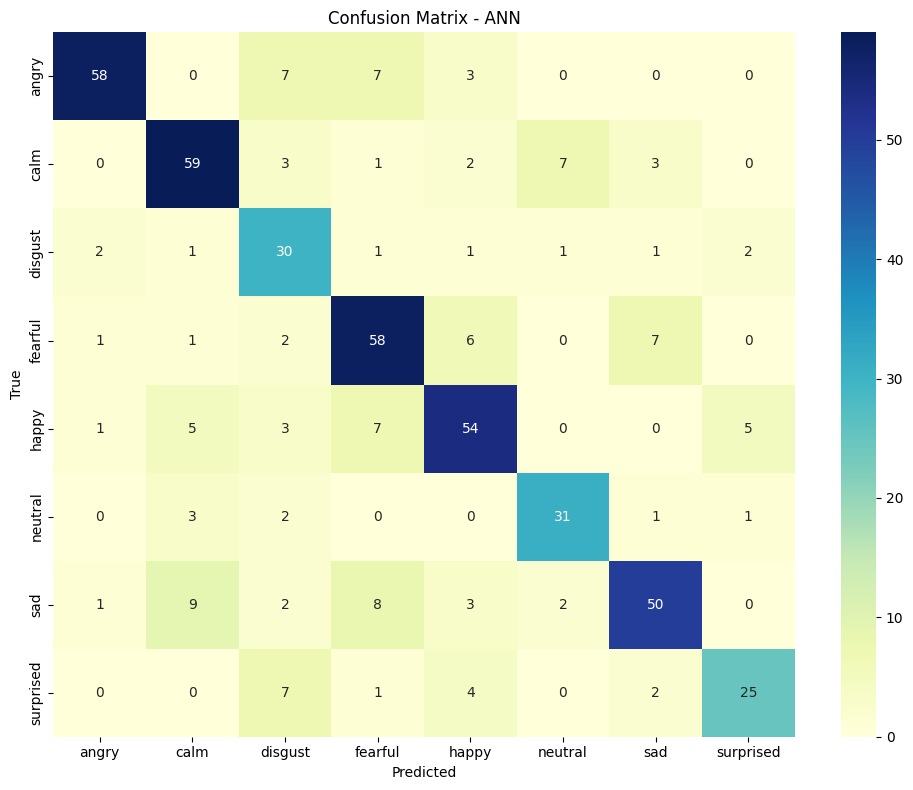

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n✅ Accuracy: {acc:.4f}")
print(f"✅ Weighted F1 Score: {f1:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ANN")
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

X_filtered = []
y_filtered = []

X = np.load("data/X_ann_features.npy")
y = np.load("data/y_ann_labels.npy")

for xi, yi in zip(X, y):
    if yi != 'disgust':
        X_filtered.append(xi)
        y_filtered.append(yi)

X_filtered = np.array(X_filtered)
y_filtered = np.array(y_filtered)

# Encode labels again (no 'disgust')
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.1790 - loss: 2.0167 - val_accuracy: 0.3204 - val_loss: 1.7000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2656 - loss: 1.7768 - val_accuracy: 0.3370 - val_loss: 1.6664
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3491 - loss: 1.6401 - val_accuracy: 0.4503 - val_loss: 1.5566
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3275 - loss: 1.6725 - val_accuracy: 0.4586 - val_loss: 1.4824
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3773 - loss: 1.5476 - val_accuracy: 0.4834 - val_loss: 1.4098
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4288 - loss: 1.4641 - val_accuracy: 0.5276 - val_loss: 1.3084
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4669 - loss: 1.3866 - val_accuracy: 0.5276 - val_loss: 1.2466
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4804 - loss: 1.3397 - val_accuracy: 0.5608 - val_loss: 1

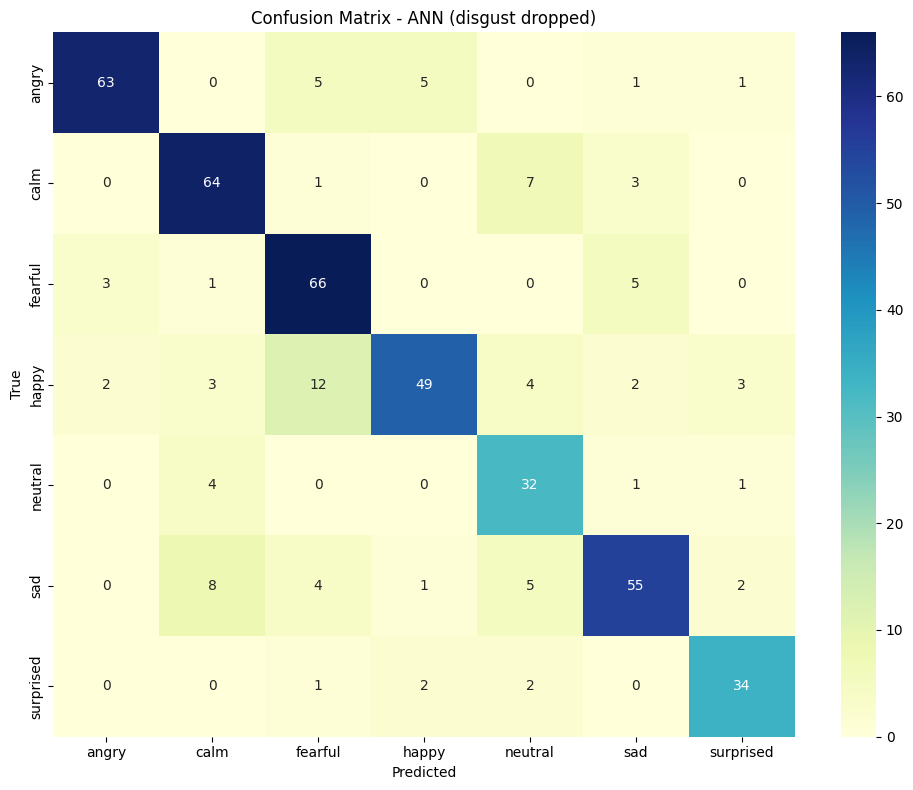

In [ ]:
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

# ANN model (same architecture)
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Predict
y_pred = np.argmax(model.predict(X_test), axis=1)

# Evaluate
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n✅ Accuracy: {acc:.4f}")
print(f"✅ Weighted F1 Score: {f1:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ANN (disgust dropped)")
plt.tight_layout()
plt.show()

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

fin_model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],), activation='gelu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='gelu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='gelu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='gelu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='gelu'),
    Dropout(0.2),

    Dense(len(le.classes_), activation='softmax')
])

fin_model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fin_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 512)            │        92,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,824 (1.03 MB)

 Trainable params: 268,904 (1.03 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [62]:
import pickle

# Replace 'model' with your actual trained model variable name
with open('emotion_model.pkl', 'wb') as f:
    pickle.dump(fin_model, f)

print("✅ Model saved as emotion_model.pkl")

✅ Model saved as emotion_model.pkl


Epoch 1/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.1603 - loss: 2.3309 - val_accuracy: 0.2376 - val_loss: 1.8042 - learning_rate: 3.0000e-04
Epoch 2/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2383 - loss: 1.9837 - val_accuracy: 0.3343 - val_loss: 1.7456 - learning_rate: 3.0000e-04
Epoch 3/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2952 - loss: 1.9145 - val_accuracy: 0.3481 - val_loss: 1.6733 - learning_rate: 3.0000e-04
Epoch 4/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2899 - loss: 1.7823 - val_accuracy: 0.3370 - val_loss: 1.6430 - learning_rate: 3.0000e-04
Epoch 5/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3382 - loss: 1.7315 - val_accuracy: 0.4061 - val_loss: 1.5468 - learning_rate: 3.0000e-04
Epoch 6/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3789 - loss: 1.6172 - val_accuracy: 0.3867 - val_loss: 1.5200 - learning_rate: 3.0000e-04
Epoch 7/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.36

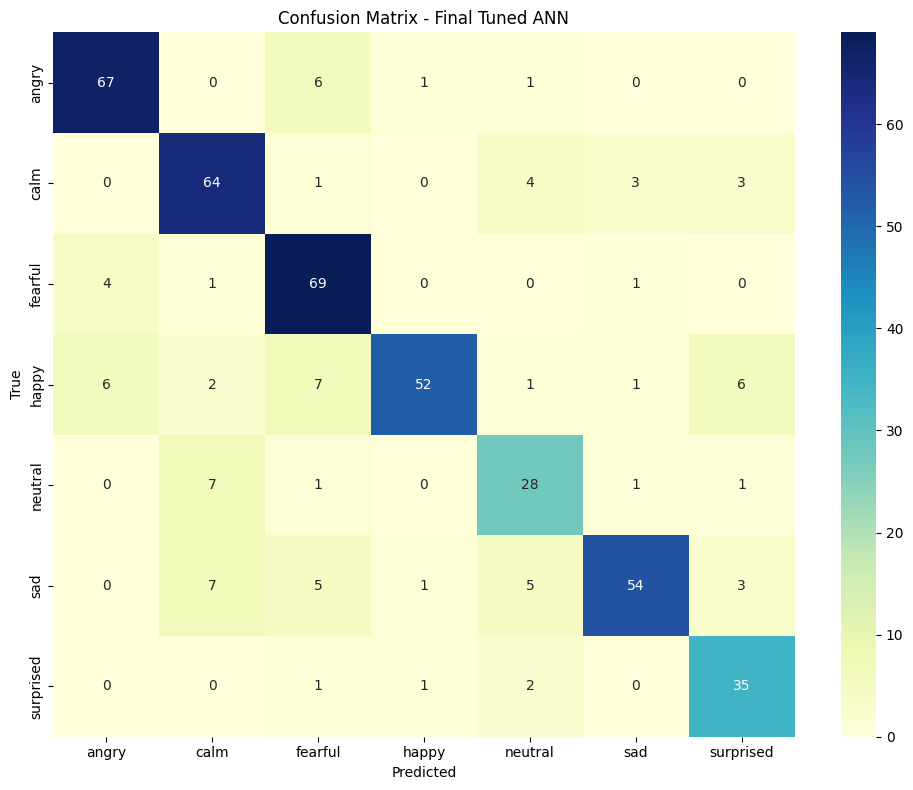

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train, num_classes=len(le.classes_))
y_test_oh = to_categorical(y_test, num_classes=len(le.classes_))
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)

# Train
history = fin_model.fit(
    X_train, y_train_oh,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

# Predict
y_pred = np.argmax(fin_model.predict(X_test), axis=1)
y_true = np.argmax(y_test_oh, axis=1)

# Results
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\n✅ Accuracy: {acc:.4f}")
print(f"✅ Weighted F1 Score: {f1:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Final Tuned ANN")
plt.tight_layout()
plt.show()

In [9]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


In [41]:
pip install streamlit librosa soundfile numpy scikit-learn

In [63]:
app_code = """
import streamlit as st
import librosa
import numpy as np
import soundfile as sf
import pickle
import os

# Load the trained model
@st.cache_resource
def load_model():
    with open("emotion_model.pkl", "rb") as file:
        return pickle.load(file)

# Load label encoder
@st.cache_resource
def load_label_encoder():
    with open("label_encoder.pkl", "rb") as file:
        return pickle.load(file)

model = load_model()
label_encoder = load_label_encoder()

# Extract full 179 features (same as training)
def extract_features(file_path):
    try:
        y_audio, sr = librosa.load(file_path, sr=22050)

        n_mfcc = 40
        n_mels = 125
        n_chroma = 10

        mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        mel = librosa.feature.melspectrogram(y=y_audio, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel)
        mel_mean = np.mean(mel_db, axis=1)

        zcr = np.mean(librosa.feature.zero_crossing_rate(y_audio))
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y_audio, sr=sr))
        chroma = librosa.feature.chroma_stft(y=y_audio, sr=sr, n_chroma=n_chroma)
        chroma_mean = np.mean(chroma, axis=1)

        # Default values for intensity and gender during inference
        features = np.concatenate([
            mfcc_mean, mel_mean, [zcr], [bandwidth], chroma_mean, [1], [1]
        ])

        return features

    except Exception as e:
        st.error(f"Error during feature extraction: {e}")
        return None

# Streamlit app layout
st.set_page_config(page_title="Emotion Detection from Audio", layout="centered")
st.title("🎧 Emotion Detection from Voice")
st.markdown("Upload a `.wav` audio file to detect the **emotion** expressed in it.")

uploaded_file = st.file_uploader("Choose an audio file", type=["wav"])

if uploaded_file is not None:
    temp_path = "temp_audio.wav"
    with open(temp_path, "wb") as f:
        f.write(uploaded_file.getbuffer())

    st.audio(uploaded_file, format='audio/wav')

    features = extract_features(temp_path)

    if features is not None:
        features = features.reshape(1, -1)
        prediction = model.predict(features)
        predicted_index = np.argmax(prediction)
        predicted_emotion = label_encoder.inverse_transform([predicted_index])[0]
        st.success(f"🎯 Predicted Emotion: **{predicted_emotion.capitalize()}**")

    if os.path.exists(temp_path):
        os.remove(temp_path)
"""

# Save to app.py
with open("app.py", "w") as f:
    f.write(app_code)

# Download it from Colab
from google.colab import files
files.download("app.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
import pickle

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)